In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf
from pyspark.sql.types import *
import random
import scipy.signal as signal
import scipy.io
import warnings

warnings.filterwarnings('ignore')

## Load & Explore Data

### Perform EDA & Pre-processing on random sample of 3 activities

In [330]:
# Load exercise dataset 
exercise_dataset = scipy.io.loadmat('bigfiles/exercise_data.50.0000_singleonly.mat', struct_as_record=False)

# Load activities and data full objects
exercise_constants = exercise_dataset['exerciseConstants'][0][0].activities
subject_data = exercise_dataset['subject_data']

# extract activities names into an array
all_activities = []
for act in exercise_constants[0]:
    all_activities.append(act[0])

In [331]:
activities_to_remove = ['Tap Left Device', 'Tap Right Device', 'Device on Table', 
'Non-Exercise', 'Note', 'Unlisted Exercise', 'Rest',
'Arm Band Adjustment', '<Initial Activity>', 'Invalid', 'Arm straight up', 
'Tap IMU Device', 'Triceps extension (lying down) (left arm)',
'Triceps extension (lying down) (right arm)', 'Alternating Dumbbell Curl']

# Remove activities from all_activities that aren't exercises or have too <2 sets in the dataset
for activity in activities_to_remove:
    all_activities.remove(activity)

In [332]:
# Only take data from 3 random exercises as POC of this data processing pipeline
activities_to_process = random.choices(all_activities, k=3)
print(activities_to_process)

['Triceps extension (lying down)', 'Squat (arms in front of body, parallel to ground)', 'Bicep Curl']


In [333]:
# define dictionaries for accelerometer and gyroscope data
activities_accelerometer_data_dict = { activities_to_process[0]: [], activities_to_process[1]: [], activities_to_process[2]: []}
activities_gyroscope_data_dict = { activities_to_process[0]: [], activities_to_process[1]: [], activities_to_process[2]: []}
rep_counts_actual = []

# iterate over subject data to search for those activities and save the data related
for data_item in subject_data:
    for x in data_item:
        if len(x) > 0:
            if x[0] is not None and len(x[0]) > 0:
                data_activity_name = x[0,0].activityName[0]
                data_activity_reps = x[0,0].activityReps[0]
                data_item_accelDataMatrix = x[0,0].data[0,0].accelDataMatrix
                data_item_gyroDataMatrix = x[0,0].data[0,0].gyroDataMatrix
                if data_activity_name in activities_to_process:
                    activities_accelerometer_data_dict[data_activity_name].append(data_item_accelDataMatrix)
                    activities_gyroscope_data_dict[data_activity_name].append(data_item_gyroDataMatrix)
                    rep_counts_actual.append(data_activity_reps)

In [334]:
# Turn activities_gyroscope_data_dict and activities_accelerometer_data_dict into a spark dataframe
ss = SparkSession.builder.getOrCreate()
sc = ss.sparkContext
sc.setLogLevel("ERROR")

# Create schema for signal data
schema = StructType([
    StructField("overall_set_num", IntegerType(), True),
    StructField("activity_name", StringType(), True),
    StructField("activity_set_num", IntegerType(), True),
    StructField("time", DoubleType(), True),
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True),
    StructField("z", DoubleType(), True)
])

# Initialize empty dataframes
gyroscope_df = ss.createDataFrame(sc.emptyRDD(), schema)
accelerometer_df = ss.createDataFrame(sc.emptyRDD(), schema)
gyroscope_data = []
accelerometer_data = []

# Iterate over activities and append data to dataframes
overall_set_num = 0
for activity in activities_to_process:
    for activity_set_num, activity_set in enumerate(activities_gyroscope_data_dict[activity]):
        for time_point in activity_set:
            data_row = (overall_set_num, str(activity), activity_set_num, float(time_point[0]), float(time_point[1]), float(time_point[2]), float(time_point[3]))
            gyroscope_data.append(data_row)
        overall_set_num += 1
    overall_set_num -= activity_set_num
    for activity_set_num, activity_set in enumerate(activities_accelerometer_data_dict[activity]):
        for time_point in activity_set:
            data_row = (overall_set_num, str(activity), activity_set_num, float(time_point[0]), float(time_point[1]), float(time_point[2]), float(time_point[3]))
            accelerometer_data.append(data_row)
        overall_set_num += 1

# Create dataframes directly from the lists of data rows
gyroscope_df = ss.createDataFrame(gyroscope_data, schema)
accelerometer_df = ss.createDataFrame(accelerometer_data, schema)

In [335]:
# subtract 1 from every value in accelerometer_df.overall_set_num
accelerometer_df = accelerometer_df.withColumn("overall_set_num", accelerometer_df.overall_set_num - 1)

In [337]:
assert(accelerometer_df.count() == gyroscope_df.count())
assert(accelerometer_df.agg({"overall_set_num": "max"}).collect()[0][0] == gyroscope_df.agg({"overall_set_num": "max"}).collect()[0][0])

In [338]:
# save dataframes to csv
gyroscope_df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("bigfiles/gyroscope_data0624.csv")
accelerometer_df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("bigfiles/accelerometer_data0624.csv")

# load dataframes from csv
#gyroscope_df = ss.read.csv("bigfiles/gyroscope_data.csv", header=True, inferSchema=True)
#accelerometer_df = ss.read.csv("bigfiles/accelerometer_data.csv", header=True, inferSchema=True)


### Visualizations

#### Accelerometer Measurements chart (only the first result of exercises per activity has been taken)

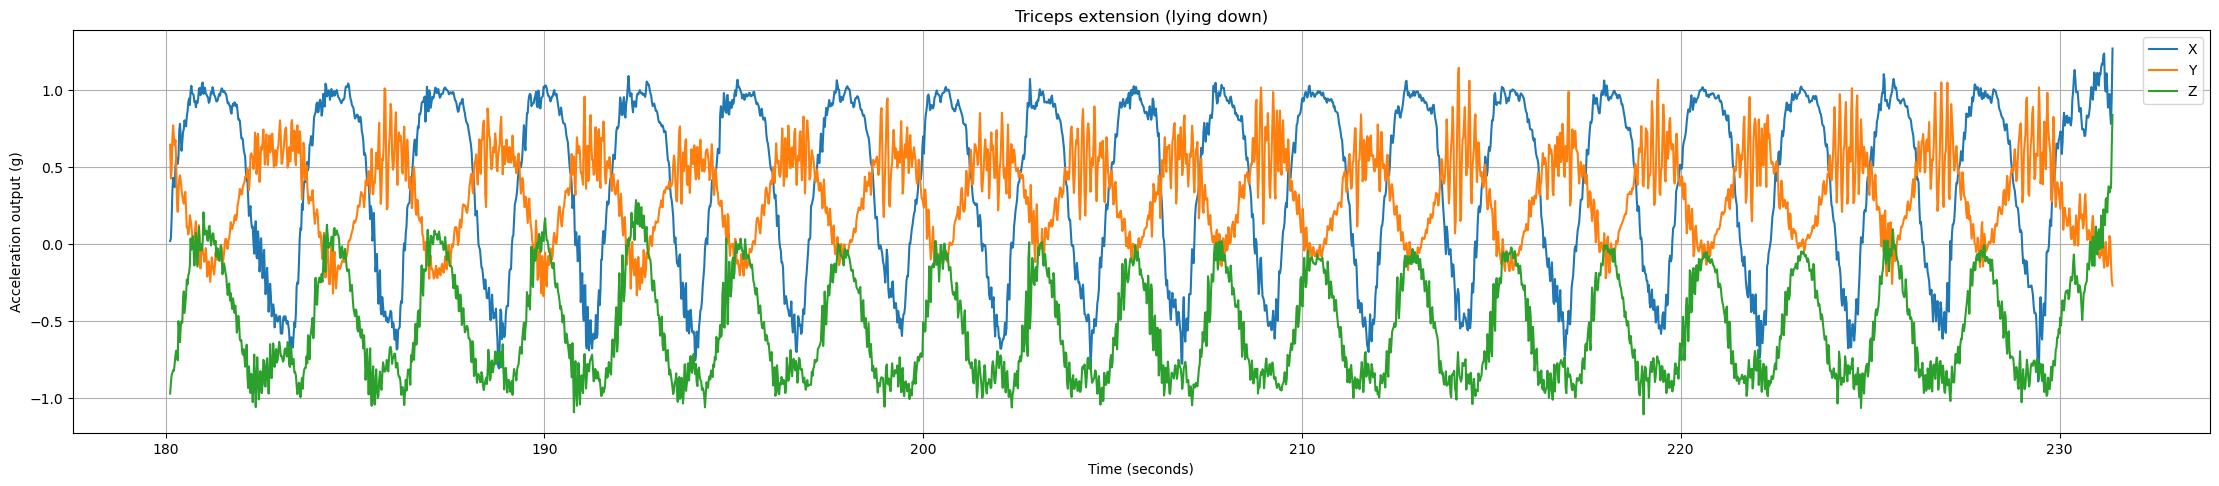

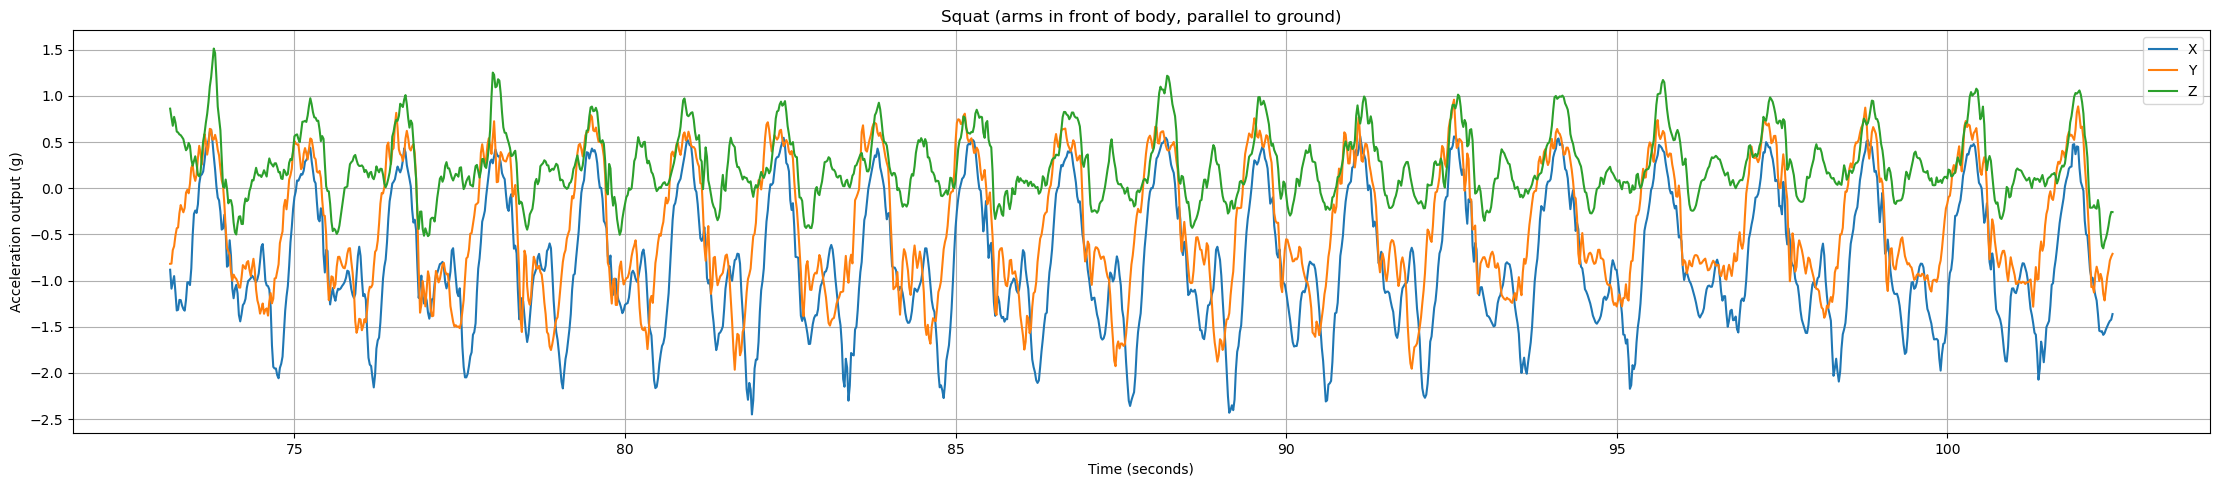

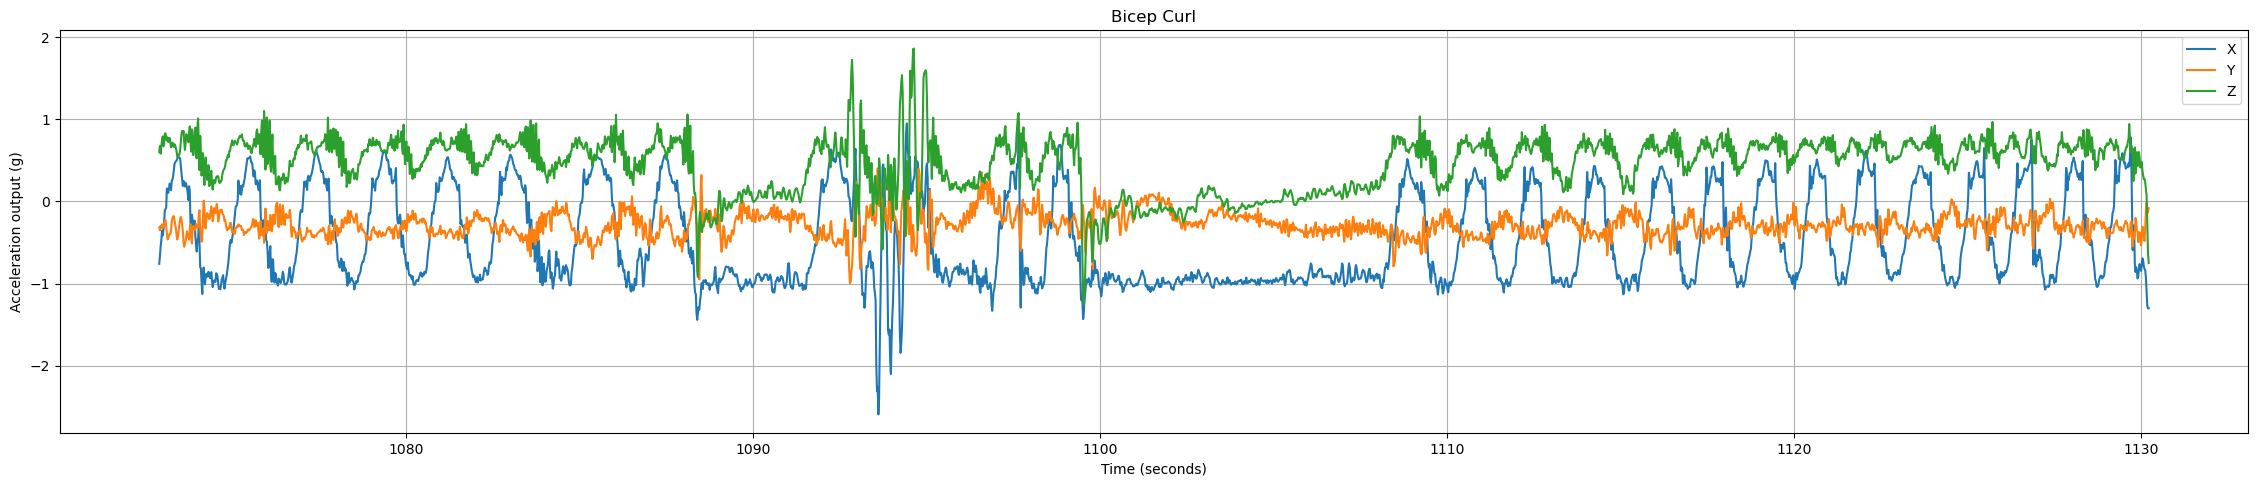

In [339]:
# Data to graph
for activity in activities_to_process:
       t, x, y, z = [], [], [], []

       for data_activity in activities_accelerometer_data_dict[activity][0]: # take only the values corresponding to the results of the first excersise
              t.append(data_activity[0]) # time value
              x.append(data_activity[1]) # X value
              y.append(data_activity[2]) # Y value
              z.append(data_activity[3]) # Z value

       fig, ax = plt.subplots()
       ax.plot(t, x, label = 'X')
       ax.plot(t, y, label = 'Y')
       ax.plot(t, z, label = 'Z')

       ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title=activity)
       ax.grid()

       fig.tight_layout()
       fig.set_size_inches(25, 5)

       plt.legend()
       plt.show()

#### Gyroscope Measurements chart (only the first result of exercises per activity has been taken)

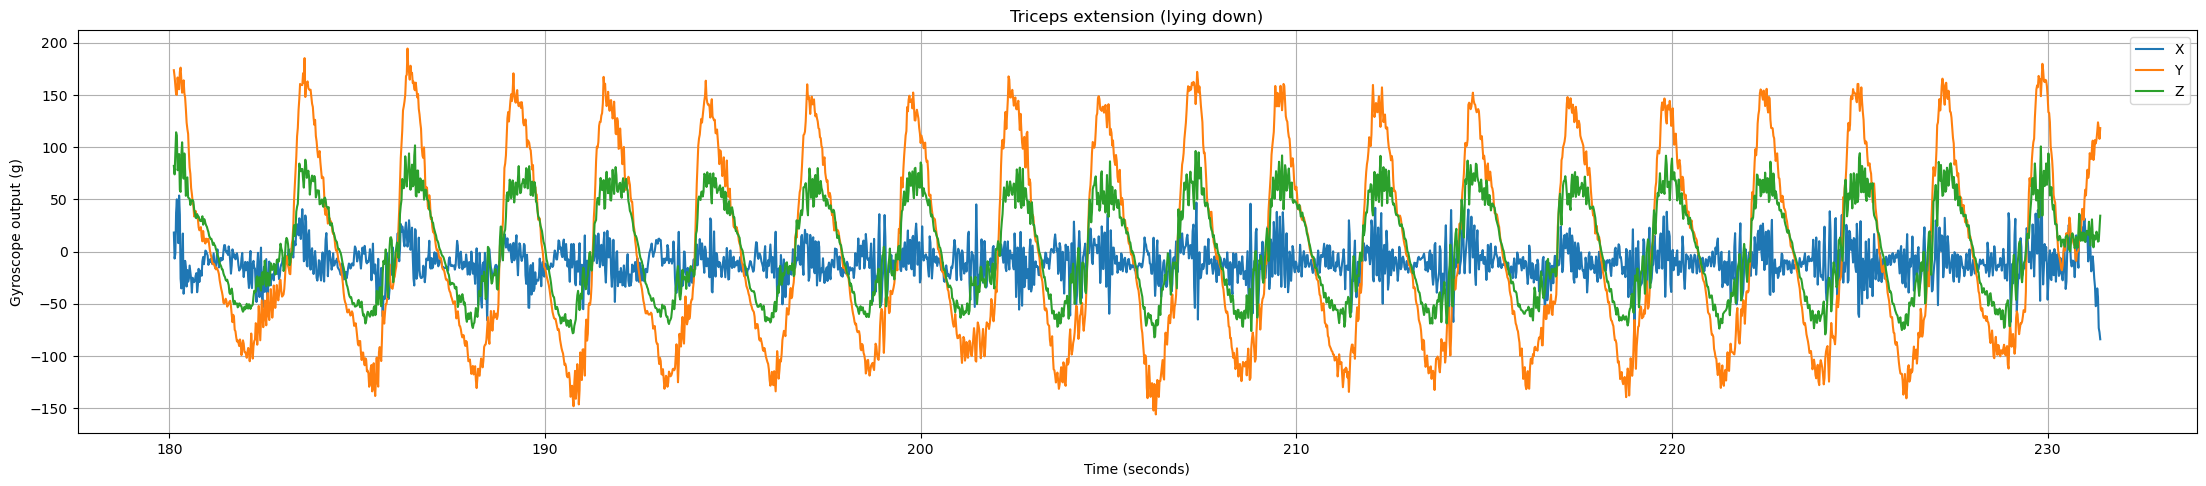

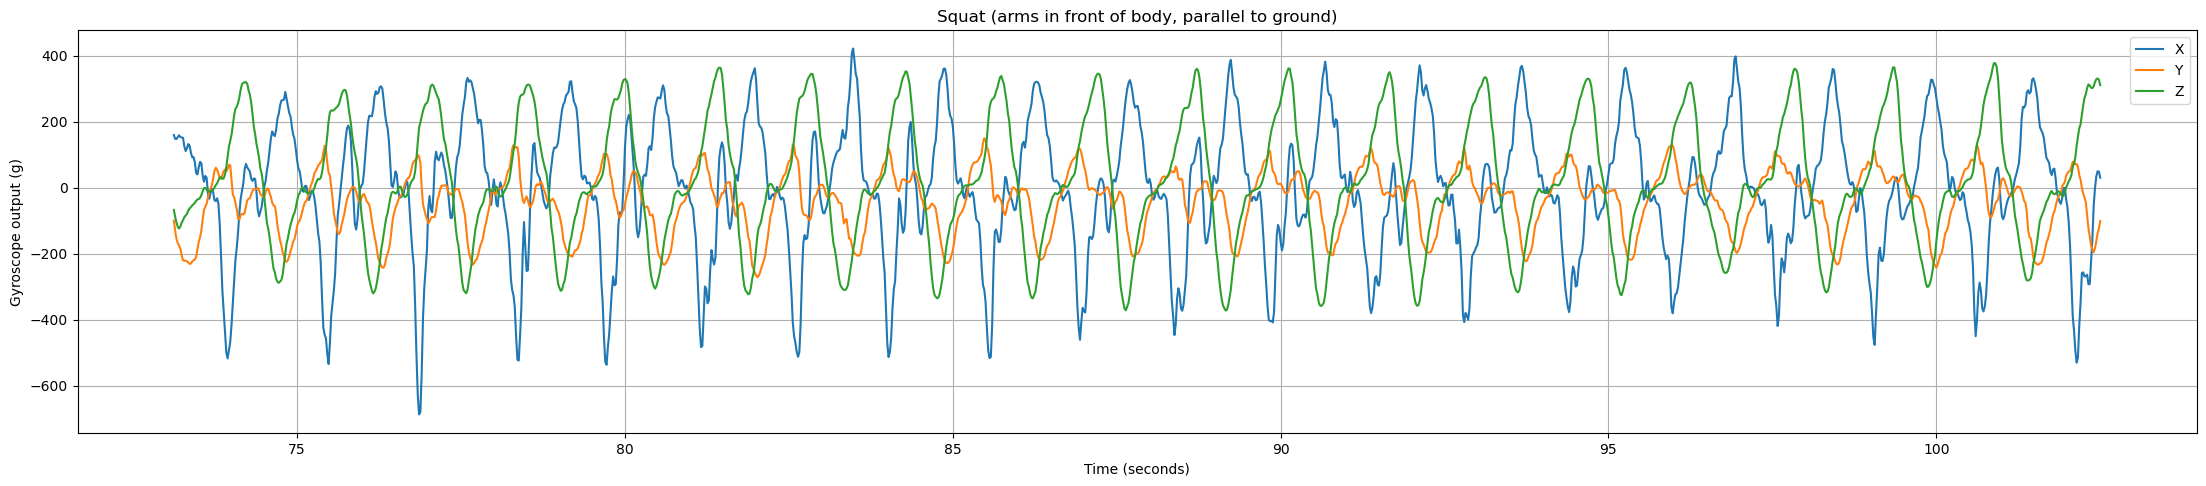

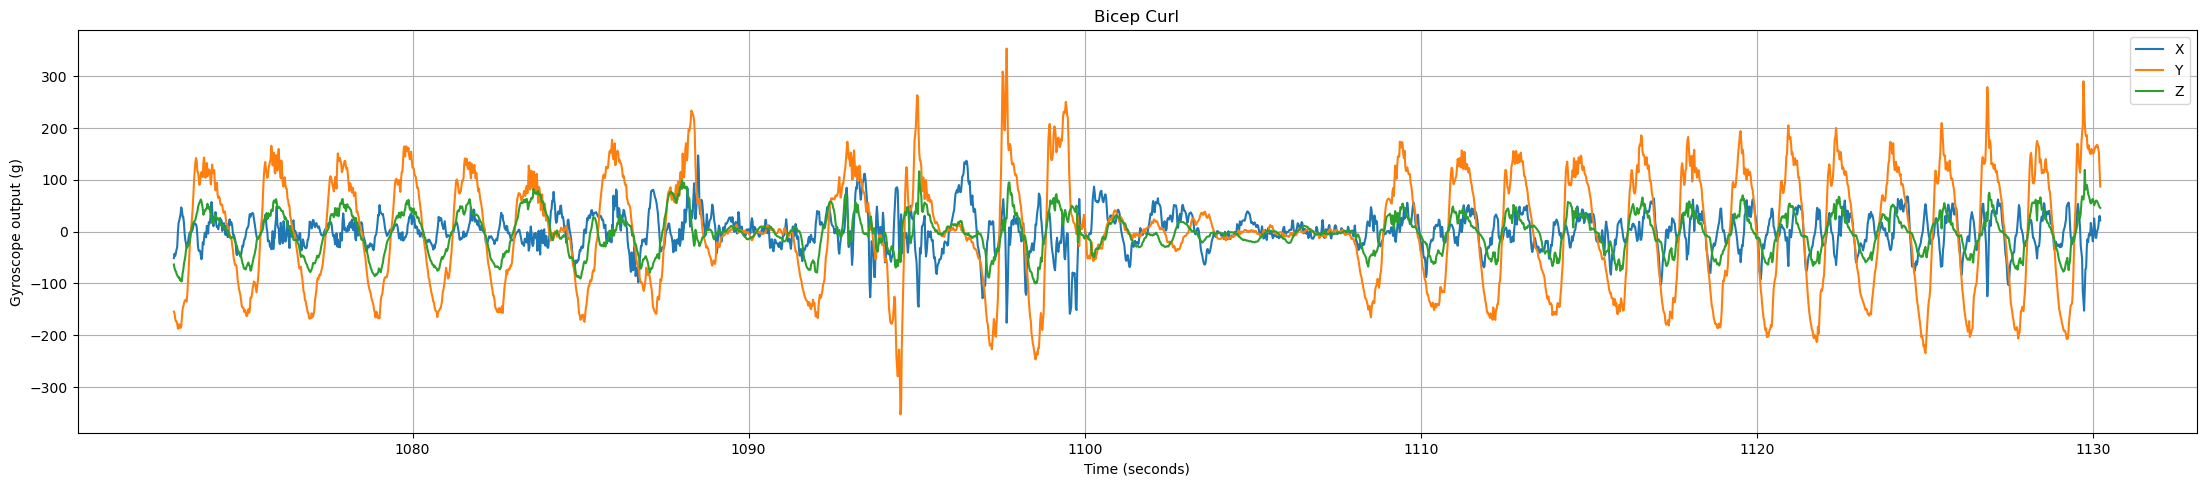

In [340]:
# Data to graph
for activity in activities_to_process:
       t, x, y, z = [], [], [], []

       for data_activity in activities_gyroscope_data_dict[activity][0]: # take only the values corresponding to the results of the first excersise
              t.append(data_activity[0]) # time value
              x.append(data_activity[1]) # X value
              y.append(data_activity[2]) # Y value
              z.append(data_activity[3]) # Z value

       fig, ax = plt.subplots()
       ax.plot(t, x, label = 'X')
       ax.plot(t, y, label = 'Y')
       ax.plot(t, z, label = 'Z')

       ax.set(xlabel='Time (seconds)', ylabel='Gyroscope output (g)', title=activity)
       ax.grid()

       fig.tight_layout()
       fig.set_size_inches(25, 5)

       plt.legend()
       plt.show()

## Segmentation Pre-Processing
Given data points containing x,y,z, and time, smooth this data with a Butterworth low-pass filter (-60dB at 20Hz), then windowed into 5-second windows sliding at 1/50 of a second (i.e., each 5s window shares 4.8s of data with the previous window). Then perform PCA to get the computed features

In [341]:
def apply_butterworth_lowpass(data):
    sampling_rate = 50 # sampling_rate of 50 Hz
    cutoff_freq = 20 # 20 Hz as specified by the paper (TODO try different values)
    filter_order = 4  # Specify the desired filter order (TODO try different values)
    nyquist_frequency = 0.5 * sampling_rate  
    normalized_cutoff_frequency = cutoff_freq / nyquist_frequency
    b, a = signal.butter(filter_order, normalized_cutoff_frequency, btype='low', analog=False, output='ba')
    smoothed_data = signal.lfilter(b, a, data)
    return smoothed_data#.flatten()


In [342]:
def preprocess(data_source, source_name):
    window_duration = 5  # Window duration in seconds
    sampling_rate = 50  # Sampling rate in Hz
    window_size = int(window_duration * sampling_rate) # 250
    overlap = 10 # distinct 10 points 200ms, shared 4.8 seconds => 240 overlap

    # initialize schemas for accelerometer and gyroscope pyspark dataframes
    # accelerometer features: aYZPC and aX
    # gyroscope features: gPC
    aX_cols = [f"x{i}" for i in range(window_size)]
    aYZPC1_cols = [f"aYZPC{i}" for i in range(window_size)]
    gPC1_cols = [f"gPC{i}" for i in range(window_size)]

    common_fields = [StructField("window_index", IntegerType(), True),
        StructField("overall_set_num", IntegerType(), True),
        StructField("activity_name", StringType(), True),
        StructField("activity_set_num", IntegerType(), True)]

    yz_signal_cols = ['y','z']
    xyz_signal_cols = ['x'] + yz_signal_cols
    yzfields = [StructField(f"y", FloatType(), True), 
        StructField(f"z", FloatType(), True)]
    
    # set the correct schema depending on the source_name
    if source_name == "accelerometer":
        pca_schema = StructType(yzfields)
        input_cols = yz_signal_cols
        output_schema = StructType(common_fields + [StructField(col, FloatType(), True) for col in aX_cols + aYZPC1_cols])
    elif source_name == "gyroscope":
        pca_schema = StructType(yzfields + \
            [StructField(f"x", FloatType(), True)])
        input_cols = xyz_signal_cols
        output_schema = StructType(common_fields + [StructField(col, FloatType(), True) for col in gPC1_cols])
    
    # iterate over all distinct set_nums in the data table
    # so that we can process 1 exercise set's signal in all 4 dimensions (x, y, z, t) at a time
    output_table = []
    overall_set_nums = data_source.select('overall_set_num').distinct().rdd.flatMap(lambda x: x).collect()
    for overall_set_num in overall_set_nums: 
        # get current set information
        set_data = data_source.filter(data_source.overall_set_num == overall_set_num)
        activity_name = set_data.select('activity_name').first()[0]
        activity_set_num = set_data.select('activity_set_num').first()[0]

        # apply butterworth lowpass filter to x, y, z columns
        x = list(set_data.select(set_data['x']).toPandas()['x'])
        y = list(set_data.select(set_data['y']).toPandas()['y'])
        z = list(set_data.select(set_data['z']).toPandas()['z'])
        smoothed_x = apply_butterworth_lowpass(x)
        smoothed_y = apply_butterworth_lowpass(y)
        smoothed_z = apply_butterworth_lowpass(z)
    
        # Slide the window over to compute features for each 5 second interval/window
        for i in range(0, len(smoothed_x) - window_size + 1, overlap):
            # Get the windowed data that we'll use to perform PCA
            individual_window_table = {col: [] for col in input_cols} # initialize empty table
            if source_name == "gyroscope": # to compute gPC1 with all 3 dimensions (x,y,z)
                individual_window_table["x"] = smoothed_x[i:i+window_size]
            individual_window_table["y"] = smoothed_y[i:i+window_size]
            individual_window_table["z"] = smoothed_z[i:i+window_size]

            # Create dict individual_window_table to pandas DF
            individual_window_table = pd.DataFrame.from_dict(individual_window_table)
            # Convert the pandas DataFrame to a PySpark DataFrame
            pyspark_window_df = ss.createDataFrame(individual_window_table, pca_schema)

            # Combine the input columns into a single vector column
            assembler = VectorAssembler(inputCols=input_cols, outputCol='features_vect')
            assembled_df = assembler.transform(pyspark_window_df)

            # Perform PCA and keep only the first principal component
            pca = PCA(k=1, inputCol='features_vect', outputCol='pca_features')
            pca_model = pca.fit(assembled_df)
            pca_result = pca_model.transform(assembled_df).select('pca_features')

            # Flatten the pca_result DataFrame so that each element is a floatType and then transpose it
            pca_result = pca_result.rdd.map(lambda x: [float(element) for element in x.pca_features.toArray()]) \
                .flatMap(lambda x: x).collect()

            # Append the pca_row and other columns to the output_table
            # TODO: maybe using smoothed_x would be better than raw x, try this to see if it improves performance
            if source_name == "accelerometer":
                output_table.append([i, overall_set_num, activity_name, activity_set_num] + x[i:i+window_size]+ pca_result)
            elif source_name == "gyroscope":
                output_table.append([i, overall_set_num, activity_name, activity_set_num] + pca_result)
            
        df = ss.createDataFrame(output_table, output_schema)
    return df

In [343]:
test_g = preprocess(gyroscope_df, 'gyroscope')
# 1 minute for just 1 set/exercise

In [ ]:
accelerometer_features = preprocess(accelerometer_df, 'accelerometer')

#### test stuff
Ideally - don't run the next few cells bc I like to keep the output

In [212]:
test_g.filter(test_g.overall_set_num == 0).select('t0', 't249').show()

+------------------+------------------+
|                t0|              t249|
+------------------+------------------+
|202.97801843365608|207.95796981704166|
| 203.1780164811816| 208.1579678645672|
| 203.3780145287071| 208.3579659120927|
|203.57801257623265|208.55796395961823|
|203.77801062375818|208.75796200714376|
| 203.9780086712837|208.95796005466931|
|204.17800671880926| 209.1579581021948|
|204.37800476633475|209.35795614972034|
|204.57800281386028| 209.5579541972459|
|204.77800086138578| 209.7579522447714|
|204.97799890891136| 209.9579502922969|
|205.17799695643686|210.15794833982244|
|205.37799500396238|  210.357946387348|
|205.57799305148788| 210.5579444348735|
|205.77799109901343|210.75794248239902|
|205.97798914653896|210.95794052992457|
|206.17798719406449| 211.1579385774501|
|206.37798524159004| 211.3579366249756|
|206.57798328911554|211.55793467250112|
|206.77798133664106|211.75793272002667|
+------------------+------------------+
only showing top 20 rows



In [64]:
df_gyroscope = preprocess(gyroscope_df, 'gyroscope')

In [65]:
df_accelerometer = preprocess(accelerometer_df, 'accelerometer')

## Segmentation Feature Computation 
aX, aYZPC1, and gPC1
- aX: the X-axis accelerometer signal
- aYZPC1: the projection of only the Y and Z axes onto the first principal component of those two axes. This indicates the movement perpendicular to the user's arm, which allows us to learn about the Y and Z axes regardless of the unknown rotation of the the accelerometer on the armband
- gPC1: the projection of the three-dimensional accelerometer signal (x,y,z) onto its first principal component

In [ ]:
gyroscope_features = preprocess(gyroscope_df, 'gyroscope')

In [ ]:
accelerometer_features = preprocess(accelerometer_df, 'accelerometer')

## Join both dataframes
(TODO)

In [ ]:
# join gyroscope_features and accelerometer_features by overall_set_num, window_index, activity_name
joined_sparkdf = gyroscope_features.join(
    accelerometer_features,
    (gyroscope_features["overall_set_num"] == accelerometer_features["overall_set_num"]) &
    (gyroscope_features["window_index"] == accelerometer_features["window_index"]) &
    (gyroscope_features["activity_name"] == accelerometer_features["activity_name"]),
    "inner"
)

## Recognition features (computed for each signal)
20 features computed over each of 3 derived signals (aX, aYZPC1, and gPC1)
- Autocorrelation bins: 5 evenly-spaced bins of the 5- second autocorrelation – summed per bin (5 features).
- RMS: The root-mean-square amplitude of the signal.
- Power bands: The magnitude of the power spectrum in 10 bands spaced linearly from 0.1-25Hz (10 features).
- Mean, standard deviation, kurtosis, interquartile range (4 features).

In [ ]:
# TODO: test

def get_autocorrelation_bins(set_df, col):
    # Compute the autocorrelation for current column (col)
    window = Window.orderBy("signal")
    set_df = set_df.withColumn("lag", lag(col("signal")).over(window))
    lags = np.array(set_df.select("lag").rdd.flatMap(lambda x: x).collect())
    signals = np.array(set_df.select("signal").rdd.flatMap(lambda x: x).collect())
    autocorrelation = np.correlate(signals, lags, mode="full")

    # Bin autocorrelation values
    num_bins = 5
    ac_length = len(autocorrelation)

    # Compute the lag interval between consecutive bins
    lag_interval = ac_length / num_bins

    # Create an array to store the sums for each bin
    bin_sums = np.zeros(num_bins)

    # Iterate over the autocorrelation values and add to the corresponding bin
    for i, value in enumerate(autocorrelation):
        bin_index = int(i // lag_interval)
        if bin_index < num_bins:
            bin_sums[bin_index] += value

    return bin_sums

def get_rms(set_df, col):
    # Calculate the RMS amplitude
    rms_df = set_df.select(sqrt(avg(abs(col("signal").cast("double")) ** 2)).alias("rms_amplitude"))
    return rms_df.first()["rms_amplitude"]

def get_mean(set_df, col):
    # Calculate the mean
    mean_df = set_df.select(avg(col("signal")).alias("mean"))
    return mean_df.first()["mean"]

def get_stddev(set_df, col):
    # Calculate the standard deviation
    stddev_df = set_df.select(stddev(col("signal")).alias("stddev"))
    return stddev_df.first()["stddev"]

def get_kurtosis(set_df, col):
    # Calculate the kurtosis
    kurtosis_df = set_df.select(kurtosis(col("signal")).alias("kurtosis"))
    return kurtosis_df.first()["kurtosis"]

def get_interquartile_range(set_df, col):
    # Calculate the interquartile range
    quartiles = set_df.approxQuantile(col, [0.25, 0.75], 0.0)
    iqr = quartiles[1] - quartiles[0]
    return iqr

def get_powerbands(set_df, col):
    # Define the frequency bands
    lower_bounds = [0.1, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5]
    upper_bounds = [2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0]

    # Convert frequency column to vector column
    vectorAssembler = VectorAssembler(inputCols=["frequency"], outputCol="features")
    set_df = vectorAssembler.transform(set_df)

    # Define a user-defined function (UDF) to compute the power spectrum
    def compute_power_spectrum(features):
        power_spectrum = [value * value for value in features]
        return Vectors.dense(power_spectrum)

    compute_power_spectrum_udf = udf(compute_power_spectrum, DoubleType())

    # Compute the power spectrum and create a new column
    df = df.withColumn("power_spectrum", compute_power_spectrum_udf("features"))

    # Define bucketizer splits based on the frequency bands
    bucketizer = Bucketizer(splits=[lower_bounds, upper_bounds], inputCol="frequency", outputCol="bucket")

    # Apply bucketizer and compute the sum of power spectrum within each band
    df = bucketizer.transform(df)
    result = df.groupby("bucket").agg({"power_spectrum": "sum"}).orderBy("bucket")

    # Show the computed power bands
    result.show()

    return result

In [ ]:
derived_signals = ['aYZPC1', 'aX', 'gPC1']
for col in derived_signals:
    get_autocorrelation_bins(set_df, col)